In [5]:
import tensorflow as tf
import os
import random
import jieba
import numpy as np
import h5py
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import utils as utl
from data_loader import load_traindata, load_valdata
from vis_lstm_san import VisLSTM
import cv2
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [7]:
k = cv2.imread('D:/pycharmWork/人工智能Tensorflow/Chinese-VQA/Data/train2014/COCO_train2014_000000000025.jpg')

In [11]:
k  = cv2.imdecode(np.fromfile(image_path,dtype=np.uint8),-1)

In [12]:
k.shape

(426, 640, 3)

In [2]:
EPOCHS = 15
BATCH_SIZE = 1
EMB_SIZE = 512
HIDDEN_SIZE = 512
ATT_STEPS = 2
train_h5_name = r'C:/train_block5.h5'
val_h5_name = r'C:/val_block5.h5'

In [3]:
h5f_train = h5py.File(train_h5_name, 'r')
h5f_val = h5py.File(val_h5_name, 'r')
dataset_train_ori, tokenizer_que, tokenizer_ans, max_que_train, max_ans_train = load_traindata()
dataset_val_ori, max_que_val, max_ans_val = load_valdata(tokenizer_que, tokenizer_ans)
vocab_size_que = len(tokenizer_que.word_counts)
vocab_size_ans = len(tokenizer_ans.word_counts)
ans_eoa_index = tokenizer_ans.word_index['<eoa>']
ans_boa_index = tokenizer_ans.word_index['<boa>']


Train_data Processing...


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Leung\AppData\Local\Temp\jieba.cache
Loading model cost 0.819 seconds.
Prefix dict has been built successfully.


que_vocab_len: 3118
ans_vocab_len: 2106
Train_data OK!
Val_data Processing...
Val_data OK!


In [4]:
dataset_train = dataset_train_ori.shuffle(160000).batch(BATCH_SIZE, drop_remainder=True)
dataset_val = dataset_val_ori.shuffle(12800).batch(BATCH_SIZE, drop_remainder=True)

# load model

In [5]:
model = VisLSTM(hidden_dim=HIDDEN_SIZE, vocab_size_que=vocab_size_que, 
                vocab_size_ans=vocab_size_ans, att_steps=ATT_STEPS)
optimizer = tf.keras.optimizers.Adam(clipnorm=1)
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='categorical_crossentropy',
                                                          reduction='none')
checkpoint_dir = './vislstm_checkpoint10'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
latest_file = tf.train.latest_checkpoint(checkpoint_dir)
epoch_point = None   # 指定加载的epoch，不指定则加载最新的一次epoch
now_epoch = 1
if epoch_point is None:
    checkpoint.restore(latest_file)
    now_epoch = int(latest_file.split('-')[-1]) + 1
else:
    checkpoint.restore(os.path.join(checkpoint_dir, 'ckpt-'+str(epoch_point)))
    now_epoch = epoch_point

In [6]:
now_epoch

8

# visual

In [21]:
# test train
for data in dataset_train:
    src = data['question']
    trg = data['answer']
    imgs_features = []
    
    for n in range(BATCH_SIZE):
        img_tmp = np.array(h5f_train[data['id'][n].numpy().decode('utf-8')], dtype=np.float32)
        img_tmp = tf.reshape(img_tmp, (-1, 512))
        imgs_features.append(img_tmp)
    imgs_features = tf.stack(imgs_features, 0)

    out, att = model(src, trg=None, image_info=imgs_features)

    for n in range(BATCH_SIZE):
        print(n, utl.getpath(data['id'][n].numpy().decode('utf-8'), mode='train'))
        print(utl.convert_text(tokenizer_que, src[n]))
        print(utl.convert_text(tokenizer_ans, trg[n]))
        print(utl.convert_text(tokenizer_ans, out[n]))
        print('*' * 30)
    break

0 ./Data/train2014/COCO_train2014_000000221311.jpg
这个 人 的 行李箱 是 什么 颜色 的 ？ 
白色 
大 红色 的 
******************************


In [65]:
# test val
for data in dataset_val:
    src = data['question']
    trg = data['answer']
    imgs_features = []
    
    for n in range(BATCH_SIZE):
        img_tmp = np.array(h5f_val[data['id'][n].numpy().decode('utf-8')], dtype=np.float32)
        img_tmp = tf.reshape(img_tmp, (-1, 512))
        imgs_features.append(img_tmp)
    imgs_features = tf.stack(imgs_features, 0)

    out, att = model(src, trg=None, image_info=imgs_features)

    for n in range(BATCH_SIZE):
        print(n, utl.getpath(data['id'][n].numpy().decode('utf-8'), mode='val'))
        print(utl.convert_text(tokenizer_que, src[n]))
        print(utl.convert_text(tokenizer_ans, trg[n]))
        print(utl.convert_text(tokenizer_ans, out[n]))
        print('*' * 30)
    break

0 ./Data/val2014/COCO_val2014_000000359303.jpg
有 几架 客机 ？ 
2 架 客机 
1 架 
******************************


In [115]:
def vis_attention(att_layer=2, mode='train'):
    if mode == 'train':
        for data in dataset_train:
            src = data['question']
            trg = data['answer']
            imgs_features = []

            for n in range(BATCH_SIZE):
                img_tmp = np.array(h5f_train[data['id'][n].numpy().decode('utf-8')], dtype=np.float32)
                img_tmp = tf.reshape(img_tmp, (-1, 512))
                imgs_features.append(img_tmp)
            imgs_features = tf.stack(imgs_features, 0)
            out, att = model(src, trg=None, image_info=imgs_features)
            break
    elif mode == 'val':
        for data in dataset_val:
            src = data['question']
            trg = data['answer']
            imgs_features = []

            for n in range(BATCH_SIZE):
                img_tmp = np.array(h5f_val[data['id'][n].numpy().decode('utf-8')], dtype=np.float32)
                img_tmp = tf.reshape(img_tmp, (-1, 512))
                imgs_features.append(img_tmp)
            imgs_features = tf.stack(imgs_features, 0)
            out, att = model(src, trg=None, image_info=imgs_features)
            break
    else:
        print('no mode!')
        return
    
    idx = 0
    print(utl.getpath(data['id'][n].numpy().decode('utf-8'), mode=mode))
    print(utl.convert_text(tokenizer_que, src[idx]))
    print(utl.convert_text(tokenizer_ans, trg[idx]))
    print(utl.convert_text(tokenizer_ans, out[idx]))
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.subplots(2, 3)
    
    att_value = att[att_layer-1][idx]
    att_value = att_value.numpy()
    att_value = att_value.reshape((14,14,1))
    ax[0,0].imshow(att_value)
    
    heatmap = att_value/np.max(att_value)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_GRAY2BGR)
    ax[0,1].imshow(heatmap)
    
    img_ori = cv2.imread(utl.getpath(data['id'][idx].numpy().decode('utf-8'), mode=mode))
    img_ori = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, img_ori.shape[:2][::-1], interpolation=cv2.INTER_CUBIC)
    ax[0,2].imshow(heatmap)
    
    heatmap_aug = np.uint8(np.clip((2 * (np.int16(heatmap) - 60) + 50), 0, 255))
    ax[1,0].imshow(heatmap_aug)
    
    superimposed_img = (heatmap_aug*.6+img_ori*0.4).astype(np.uint8)
    ax[1,1].imshow(img_ori)
    ax[1,2].imshow(superimposed_img)
    

./Data/train2014/COCO_train2014_000000524848.jpg
墙边 靠 的 什么 ？ 
一个 坐便器 
一个 坐便器 


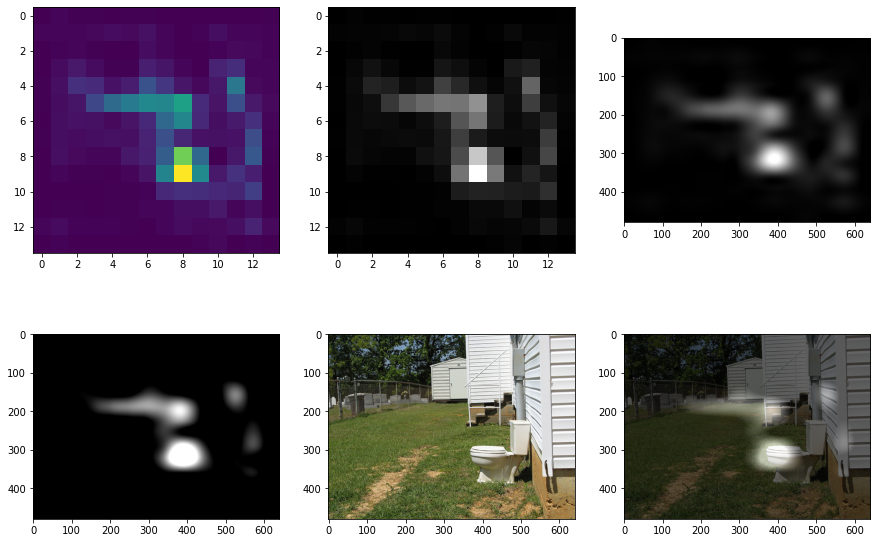

In [165]:
# 运行 test train或者val后 即可调用可视化视图
vis_attention(att_layer=1, mode='train')